In [ ]:
# default_exp doublediff_analysis

In [ ]:
#export
def calc_per_peppair_z_and_fcfc(overlapping_c1_idx, overlapping_c2_idx, ion1_c1_ints, ion1_c2_ints, ion2_c1_ints, ion2_c2_ints, ddeed_ion1_ion2):
    fcfc_res = 0
    count_fcfcs = 0
    z_summed = 0
    for idx1 in overlapping_c1_idx:
        for idx2 in overlapping_c2_idx:
            fc_ion1 = ion1_c1_ints[idx1] - ion1_c2_ints[idx2]
            fc_ion2 = ion2_c1_ints[idx1] - ion2_c2_ints[idx2]
            fcfc_idxpair = fc_ion1 - fc_ion2
            z_idxpair = ddeed_ion1_ion2.calc_zscore_from_fc(fcfc_idxpair)
            fcfc_res += fcfc_idxpair
            z_summed += z_idxpair
            count_fcfcs+=1
    if count_fcfcs==0:
        raise Exception("no idx overlap even though filtering has happened!")

    return z_summed, fcfc_res/count_fcfcs





def calculate_pairpair_overlap_factor(all_ionpairs, ion2pairs, ionpair2idx_ols, normed_c1, normed_c2, ion2diffdist, p2z):
    
    secondterm_variance = 0
    
    for ionpair in all_ionpairs:
        for ion in ionpair:
            compare_pairs = ion2pairs.get(ion)
            compare_pairs.remove(ionpair)
            
            for comp_ionpair in compare_pairs:

                comp_ion = comp_ionpair[0]

                idxs_ionpair = ionpair2idx_ols.get(ionpair)
                idxs_comp_ionpair = ionpair2idx_ols.get(comp_ionpair)
                
                n_sameidx_first = len(set(idxs_ionpair[0]).intersection(set(idxs_comp_ionpair[0])))
                n_sameidx_second = len(set(idxs_ionpair[1]).intersection(set(idxs_comp_ionpair[1])))

                deed1 = aqbg.get_subtracted_bg(ion2diffdist, normed_c1, normed_c2, ion, p2z)
                deed2 = aqbg.get_subtracted_bg(ion2diffdist, normed_c1, normed_c2, comp_ion, p2z)

                eed_ion_c1 = normed_c1.ion2background.get(ion)
                eed_ion_c2 = normed_c2.ion2background.get(ion)

                correlation_normfact = deed1.SD * deed2.SD
                
                var_overlap = len(idxs_ionpair[1])*len(idxs_comp_ionpair[1]) * n_sameidx_first * eed_ion_c1.var + len(idxs_ionpair[0])*len(idxs_comp_ionpair[0]) * n_sameidx_second * eed_ion_c2.var
                secondterm_variance += var_overlap/correlation_normfact
                
    return secondterm_variance

from scipy.stats import norm
def calculate_scaled_pval(z_sum, firstterm_variance, secondterm_variance):
    scaled_SD = np.sqrt((firstterm_variance+secondterm_variance))
    p_val = 2.0 * (1.0 -  norm(loc=0, scale= scaled_SD).cdf(abs(z_sum)))
    return p_val



In [ ]:
#export
import alphaquant.background_distributions as aqbg
import numpy as np


def calc_doublediff_score(ions1, ions2, normed_c1, normed_c2, ion2diffDist, p2z, deedpair2doublediffdist):
    """Gives a p-value for the null hypothesis: No change between the foldchanges of the ions1 in comparison to the ions2

    Args:
        ions1 (list[String]): list of ions1 to compared to ions1
        ions2 (list[String]): list of ions2  to be compared to ions1
        normed_c1 (ConditionBackground): Condition background ions1
        normed_c2 (ConditionBackground): Condition background ions2
        ion2diffDist (dict[String : EmpiricalBackground]): map from each ion to its assigned empirical background distribution
        p2z (dict[double:double]): map from p-value to z-value (lookup to improve runtime)
        deedpair2doublediffdist (dict[(EmpiricalBackground, EmpiricalBackground) : EmpiricalBackground]): map from each pair of empirical backgrounds to the subtracted empirical background representing the double differential noise

    Returns:
        double: p-value as specified above
    """
    z_total = 0
    fcfc_total = 0
    count_pairs = 0
    firstterm_variance = 0
    all_ionpairs = []
    ion2pairs = {}
    ionpair2idx_ols = {}

    nrep_c1 = len(normed_c1.ion2allvals.get(ions1[0]))
    nrep_c2 = len(normed_c2.ion2allvals.get(ions2[0]))
    
    for ion1 in ions1:
        ion1_c1_ints = normed_c1.ion2allvals.get(ion1)
        ion1_c2_ints = normed_c2.ion2allvals.get(ion1)
        for ion2 in ions2:
            ion2_c1_ints = normed_c1.ion2allvals.get(ion2)
            ion2_c2_ints = normed_c2.ion2allvals.get(ion2)

            #account for missing values: ion1 and ion2 values are only compared within the same sample -> filter for intensities that occur in the same sample for both ions
            overlapping_c1_idx = [x for x in range(nrep_c1) if (~np.isnan(ion1_c1_ints[x])) & (~np.isnan(ion2_c1_ints[x]))]
            nrep_ol_c1 = len(overlapping_c1_idx)
            if nrep_ol_c1 ==0:
                continue

            overlapping_c2_idx = [x for x in range(nrep_c2) if (~np.isnan(ion1_c2_ints[x])) & (~np.isnan(ion2_c2_ints[x]))]
            nrep_ol_c2 = len(overlapping_c2_idx)
            if nrep_ol_c2 ==0:
                continue

            #collection information for later variance calculation
            ionpair = (ion1, ion2)
            all_ionpairs.append(ionpair)
            ion2pairs[ion1] = ion2pairs.get(ion1, []) + [ionpair]
            ion2pairs[ion2] = ion2pairs.get(ion2, []) + [ionpair]
            ionpair2idx_ols[ionpair] = [overlapping_c1_idx, overlapping_c2_idx]

            #define all empirical error distributions (eed) and differential empirical error distributions (deed) and obtain the variance 
            eed_ion1_c1 = normed_c1.ion2background.get(ion1)
            eed_ion1_c2 = normed_c2.ion2background.get(ion1)

            eed_ion2_c1 = normed_c1.ion2background.get(ion2)
            eed_ion2_c2 = normed_c2.ion2background.get(ion2)

            deed_ion1 = aqbg.get_subtracted_bg(ion2diffDist,normed_c1, normed_c2,ion1, p2z)
            deed_ion2 = aqbg.get_subtracted_bg(ion2diffDist,normed_c1, normed_c2,ion2, p2z)

            #calculate the ionpair total variance as shown in Berchtold et al. EmpiReS

            ionpair_variance = (nrep_ol_c1 * nrep_ol_c2 *(deed_ion1.var + deed_ion2.var) + nrep_ol_c1 *nrep_ol_c2 *(nrep_ol_c2-1) * (eed_ion1_c1.var + eed_ion2_c1.var) +
             nrep_ol_c1 *nrep_ol_c2 *(nrep_ol_c1-1) * (eed_ion1_c2.var + eed_ion2_c2.var))/(deed_ion1.var + deed_ion2.var)

            firstterm_variance += ionpair_variance

            #calculate z-value and fcfc for the ion pair
            ddeed_ion1_ion2 = aqbg.get_doublediff_bg(deed_ion1, deed_ion2, deedpair2doublediffdist,p2z)
            z_pair, fcfc_pair = calc_per_peppair_z_and_fcfc(overlapping_c1_idx, overlapping_c2_idx, ion1_c1_ints, ion1_c2_ints, ion2_c1_ints, ion2_c2_ints, ddeed_ion1_ion2)
            z_total+=z_pair
            fcfc_total+=z_pair
            count_pairs+=1
    
    if count_pairs==0: # in this case, it was not possible to find any sample overlaps -> no comparison "possible"
        return 0, 1e-16 # classify as "dissimilar" in this case
    secondterm_variance = calculate_pairpair_overlap_factor(all_ionpairs, ion2pairs, ionpair2idx_ols, normed_c1, normed_c2, ion2diffDist, p2z)
    fcfc = fcfc_total/count_pairs
    pval = calculate_scaled_pval(z_total, firstterm_variance, secondterm_variance)

    return fcfc, pval

In [ ]:

import uuid
import alphaquant.background_distributions as aqbg
import alphaquant.benchmarking as aqbm
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def test_doublediff(num_ionsets = 10, fixed_size = None, simulate_nas = True):

    sample2cond_df = pd.DataFrame({'sample' : ['A1', 'A2', 'A3', 'B1', 'B2', 'B3','B4', 'B5', 'B6', 'B7', 'B8', 'B9','B10', 'B11', 'B12'],
    'condition' : ['A', 'A', 'A', 'B', 'B', 'B','B', 'B', 'B','B', 'B', 'B','B', 'B', 'B']})
    unnormed_df = aqbm.generate_random_input(100000, sample2cond_df,simulate_nas)
    display(unnormed_df)
    df_c1, df_c2 = get_c1_c2_dfs(unnormed_df, sample2cond_df, ["A", "B"])
    p2z = {}
    normed_c1 = aqbg.ConditionBackgrounds(df_c1, p2z)
    normed_c2 = aqbg.ConditionBackgrounds(df_c2, p2z)
    pvals = test_calc_doublediff_score(normed_c1, normed_c2, num_ionsets, fixed_size)
    return pvals


def test_calc_doublediff_score(normed_c1, normed_c2, num_ionsets, fixed_size = None):
    pvals = []
    fcfcs = []
    allions = list(set(normed_c1.ion2background.keys()).intersection(set(normed_c2.ion2background.keys())))
    allions = np.array(allions)
    if fixed_size is not None:
        ionsets = [allions[np.random.randint(len(allions), size=fixed_size)] for _ in range(num_ionsets)]
    else:
        ionsets = [allions[np.random.randint(len(allions), size=np.random.randint(1,10))] for _ in range(num_ionsets)]

    count_iters = 0
    ion2diffDist={} 
    p2z ={} 
    deedpair2doublediffdist = {}

    for ions1, ions2 in itertools.combinations(ionsets, 2):
        print(f"ionpair {len(ions1)} {len(ions2)}\n{count_iters} of {len(ionsets)*(len(ionsets)-1)/2}")
        count_iters+=1
        fcfc, p = calc_doublediff_score(ions1, ions2, normed_c1, normed_c2, ion2diffDist,p2z, deedpair2doublediffdist)
        pvals.append(p)
        fcfcs.append(fcfc)
    
    return pvals, fcfcs
    

def get_c1_c2_dfs(unnormed_df, labelmap_df, condpair, minrep = 2):
    c1_samples = labelmap_df[labelmap_df["condition"]== condpair[0]]
    c2_samples = labelmap_df[labelmap_df["condition"]== condpair[1]]
    df_c1 = unnormed_df.loc[:, c1_samples["sample"]].dropna(thresh=minrep, axis=0)
    df_c2 = unnormed_df.loc[:, c2_samples["sample"]].dropna(thresh=minrep, axis=0)

    return df_c1, df_c2


pvals_differentsizes,_ = test_doublediff(50)
pvals_fixedsize, fcfcs_fixedsize = test_doublediff(50, fixed_size = 4, simulate_nas=False)



47236


,A1,protein,A2,A3,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12
ion,,,,,,,,,,,,,,,,
pep0_LVL0_mod0_LVL1_mod0_LVL2_mod0_LVL3_mod0,NaN,P0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pep0_LVL0_mod0_LVL1_mod0_LVL2_mod0_LVL3_mod1,NaN,P0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pep1_LVL0_mod0_LVL1_mod0_LVL2_mod0_LVL3_mod0,NaN,P1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pep1_LVL0_mod0_LVL1_mod0_LVL2_mod1_LVL3_mod0,9.660167,P1,8.503843,9.240074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pep1_LVL0_mod0_LVL1_mod1_LVL2_mod0_LVL3_mod0,10.977881,P1,8.201591,7.987501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pep8433_LVL0_mod0_LVL1_mod0_LVL2_mod2_LVL3_mod1,10.687452,P7902,9.931944,9.995458,14.450303,9.377853,11.285214,14.119630,13.499421,12.810078,4.599094,12.801954,12.618471,7.475907,7.906144,6.365801
pep8434_LVL0_mod0_LVL1_mod0_LVL2_mod0_LVL3_mod0,7.893328,P7903,11.824544,6.824079,13.475129,7.693340,17.078480,10.628109,8.690026,16.527180,8.218958,10.652864,7.913345,11.443079,4.097059,13.799748
pep8434_LVL0_mod0_LVL1_mod0_LVL2_mod0_LVL3_mod1,12.914240,P7903,7.977802,9.781997,5.688507,14.185669,11.068925,9.243030,3.219845,7.406013,13.033100,9.290642,16.217054,11.944512,7.103377,12.117785


t_ion2nonan_sw 0.11984109878540039
t_intensity_selection 4.0515100955963135
t_ion2nonan_sw 0.11248898506164551
t_intensity_selection 11.443835020065308
ionpair 6 2
0 of 1225.0
ionpair 6 4
1 of 1225.0
ionpair 6 4
2 of 1225.0
ionpair 6 9
3 of 1225.0
ionpair 6 9
4 of 1225.0
ionpair 6 6
5 of 1225.0
ionpair 6 8
6 of 1225.0
ionpair 6 5
7 of 1225.0
ionpair 6 4
8 of 1225.0
ionpair 6 3
9 of 1225.0
ionpair 6 9
10 of 1225.0
ionpair 6 6
11 of 1225.0
ionpair 6 5
12 of 1225.0
ionpair 6 5
13 of 1225.0
ionpair 6 4
14 of 1225.0
ionpair 6 4
15 of 1225.0
ionpair 6 1
16 of 1225.0
ionpair 6 1
17 of 1225.0
ionpair 6 7
18 of 1225.0
ionpair 6 8
19 of 1225.0
ionpair 6 8
20 of 1225.0
ionpair 6 3
21 of 1225.0
ionpair 6 7
22 of 1225.0
ionpair 6 3
23 of 1225.0
ionpair 6 8
24 of 1225.0
ionpair 6 2
25 of 1225.0
ionpair 6 2
26 of 1225.0
ionpair 6 8
27 of 1225.0
ionpair 6 9
28 of 1225.0
ionpair 6 3
29 of 1225.0
ionpair 6 9
30 of 1225.0
ionpair 6 3
31 of 1225.0
ionpair 6 8
32 of 1225.0
ionpair 6 6
33 of 1225.0
ionpair 

,A1,protein,A2,A3,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12
ion,,,,,,,,,,,,,,,,
pep0_LVL0_mod0_LVL1_mod0_LVL2_mod0_LVL3_mod0,11.633608,P0,9.423402,10.896393,6.549017,6.089022,8.098182,9.904483,11.734169,9.957180,9.806743,11.229708,9.623451,9.925643,4.234189,15.308496
pep0_LVL0_mod0_LVL1_mod0_LVL2_mod0_LVL3_mod1,10.385999,P0,11.092740,11.463952,7.614391,8.816343,14.028837,6.388984,14.612157,18.116036,14.186134,14.872925,10.362174,13.473491,16.685063,1.286885
pep0_LVL0_mod0_LVL1_mod0_LVL2_mod1_LVL3_mod0,6.773279,P1,10.431787,11.489059,8.247245,14.893464,10.927430,0.421655,10.798996,6.641488,9.577818,7.315694,8.632723,11.890356,7.657705,6.000220
pep0_LVL0_mod0_LVL1_mod0_LVL2_mod1_LVL3_mod1,9.142587,P1,7.003772,10.383464,10.342999,11.109371,9.579356,7.896241,11.802491,10.606683,8.209526,12.807729,7.398589,9.398613,14.141964,16.225843
pep0_LVL0_mod0_LVL1_mod1_LVL2_mod0_LVL3_mod0,8.759835,P1,12.094040,9.874511,9.446519,5.145899,15.997451,7.297074,7.572125,5.782043,9.277636,14.479271,11.523379,9.100384,7.924370,9.326187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pep8438_LVL0_mod0_LVL1_mod0_LVL2_mod1_LVL3_mod0,8.887395,P7868,9.024411,9.241326,9.034984,6.917383,11.543840,9.710537,15.656170,3.675731,6.347297,4.209038,15.168792,16.374908,10.778061,3.903546
pep8439_LVL0_mod0_LVL1_mod0_LVL2_mod0_LVL3_mod0,12.068755,P7868,9.686492,9.363938,13.115396,7.458052,13.457221,11.215038,7.872641,12.706858,13.614830,5.252563,8.550571,11.360967,12.330179,7.153619
pep8439_LVL0_mod0_LVL1_mod0_LVL2_mod1_LVL3_mod0,10.856195,P7868,9.651783,8.859071,5.834637,-0.420109,9.648089,10.384138,7.545644,9.210712,9.777217,7.697293,10.997364,2.775078,10.340078,6.444264


t_ion2nonan_sw 0.12685108184814453
t_intensity_selection 4.2170491218566895
t_ion2nonan_sw 0.1260061264038086
t_intensity_selection 11.881180047988892
ionpair 4 4
0 of 1225.0
ionpair 4 4
1 of 1225.0
ionpair 4 4
2 of 1225.0
ionpair 4 4
3 of 1225.0
ionpair 4 4
4 of 1225.0
ionpair 4 4
5 of 1225.0
ionpair 4 4
6 of 1225.0
ionpair 4 4
7 of 1225.0
ionpair 4 4
8 of 1225.0
ionpair 4 4
9 of 1225.0
ionpair 4 4
10 of 1225.0
ionpair 4 4
11 of 1225.0
ionpair 4 4
12 of 1225.0
ionpair 4 4
13 of 1225.0
ionpair 4 4
14 of 1225.0
ionpair 4 4
15 of 1225.0
ionpair 4 4
16 of 1225.0
ionpair 4 4
17 of 1225.0
ionpair 4 4
18 of 1225.0
ionpair 4 4
19 of 1225.0
ionpair 4 4
20 of 1225.0
ionpair 4 4
21 of 1225.0
ionpair 4 4
22 of 1225.0
ionpair 4 4
23 of 1225.0
ionpair 4 4
24 of 1225.0
ionpair 4 4
25 of 1225.0
ionpair 4 4
26 of 1225.0
ionpair 4 4
27 of 1225.0
ionpair 4 4
28 of 1225.0
ionpair 4 4
29 of 1225.0
ionpair 4 4
30 of 1225.0
ionpair 4 4
31 of 1225.0
ionpair 4 4
32 of 1225.0
ionpair 4 4
33 of 1225.0
ionpair 4

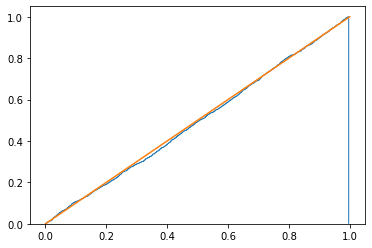

KstestResult(statistic=0.026571428571428572, pvalue=0.8187344626956405)

<AxesSubplot:>

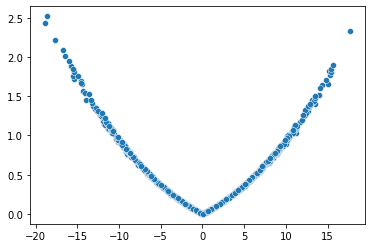

In [ ]:
import alphaquant.visualizations as aqviz
import scipy.stats as stats
import seaborn as sns

plt.hist(pvals_differentsizes, cumulative=True, bins = 1000, histtype = "step", density = True)
x = np.linspace(0,1,100)
plt.plot(x, x)
plt.show()
unidist = np.random.uniform(size=1000)

res = stats.ks_2samp(pvals_fixedsize, unidist)
display(res)
#assert statement can be placed here!

sns.scatterplot(x = fcfcs_fixedsize,y = -np.log10(pvals_fixedsize))

